# Import des packages

In [8]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Visualisation des données COMPAS

In [9]:
# On charge nos données
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df.info()

# Voir les 5 premières lignes de nos données
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


# Transformation du problème en une classification binaire

On cherche à regrouper les scores de risques en deux sous groupes :
* Ceux ayant un score au dessus ou égale à 5 (risque grand/moyen)  seront considérés comme de probables récidivistes, 
*  Ceux ayant un score en dessous de 5 (risque petit) seront considérés comme ayant peu de chance de récidiver.

On va donc ajouter une nouvelle colonne qui transforme le score de risque (`decile_score`) sous forme binaire :
* 0 correspondant à un score inférieur à 5,
* 1 correspondant à un score supérieur ou égale à 5.

In [10]:
df['is_med_or_high_risk']  = (df['decile_score']>=5).astype(int)
df.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,is_med_or_high_risk
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,1
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0


# Les critères d'impartialité

## Calibrage

On se concentre sur les individus de type caucasien et ceux de type afro-américain.

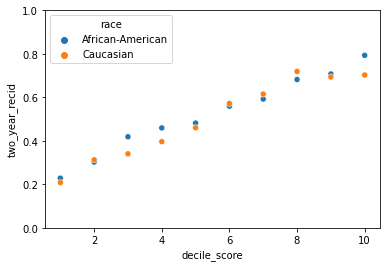

In [11]:
# On extrait de la variable 'race' seulement les individus Caucasiens et Afro-Américains
df = df[df.race.isin(["African-American","Caucasian"])]

# On regarde ensuite si un prévenu avec un certain score à la même probabilité de récidiver dans les deux groupes

d = pd.DataFrame(df.groupby(['decile_score','race']).agg({'two_year_recid': 'mean'}))
d = d.reset_index()
im = sns.scatterplot(data=d, x='decile_score', y='two_year_recid', hue='race');
im.set(ylim=(0,1));

## Parité démographique

<AxesSubplot:xlabel='decile_score', ylabel='Density'>

<AxesSubplot:xlabel='decile_score', ylabel='Density'>

Text(0, 0.5, 'Fréquence')

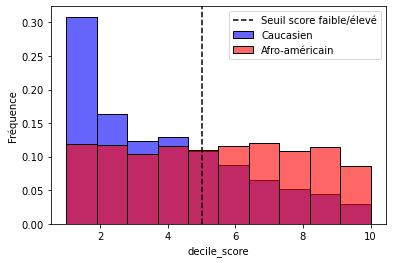

In [12]:
# Data frame comprenant que l'ethnie Caucasien
df_c = df[df['race'] == 'Caucasian'] 
ds_cau = df_c['decile_score']

# Data frame comprenant que l'ethnie Afro-Américain
df_a = df[df['race'] == 'African-American']
ds_afro = df_a['decile_score']

# Histogramme comparant la fréquence en fonction du score de chaque ethnie

sns.histplot(ds_cau, bins=10, alpha=0.6, color='blue', stat='density')
sns.histplot(ds_afro, bins=10, alpha=0.6, color='red', stat='density')
plt.axvline(5, 0, 1, color='black', linestyle='--')
plt.legend(labels=["Seuil score faible/élevé", "Caucasien", "Afro-américain"], )
plt.ylabel('Fréquence')

On peut également calculer les taux de risques de chaque ethnie.

In [13]:
r_low_c = len(ds_cau[ds_cau < 5])/len(ds_cau)
r_low_c  # Taux de risque faible chez les Caucasiens
r_high_c = len(ds_cau[ds_cau >= 5])/len(ds_cau) 
r_high_c # Taux de risque élevé chez les Caucasiens
r_low_a = len(ds_afro[ds_afro < 5])/len(ds_afro) 
r_low_a # Taux de risque faible chez les Afro-Américains
r_high_a = len(ds_afro[ds_afro >= 5])/len(ds_afro) 
r_high_a # Taux de risque élevé chez les Afro-Américains

0.6519967400162999

0.3480032599837001

0.41179653679653677

0.5882034632034632

## Égalité des chances

Text(0.5, 1.0, 'Caucasien')

(array([0.5, 1.5]),
 [Text(0, 0.5, 'Score faible'), Text(0, 1.5, 'Score élevé')])

Text(0.5, 1.0, 'Afro-américain')

(array([0.5, 1.5]),
 [Text(0, 0.5, 'Score faible'), Text(0, 1.5, 'Score élevé')])

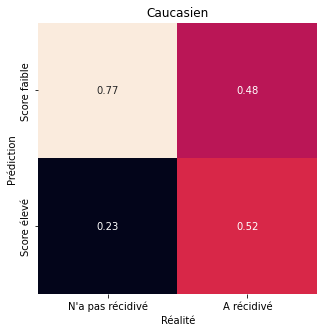

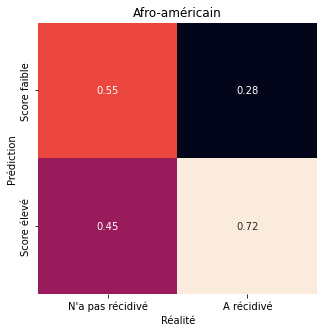

In [14]:
# Matrice de confusion pour l'ethnie Caucasien

cm = pd.crosstab(df_c['is_med_or_high_risk'], df_c['two_year_recid'], 
                               rownames=['Prédiction'], colnames=['Réalité'], normalize='columns')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, xticklabels=["N'a pas récidivé", "A récidivé"], yticklabels=["Score faible", "Score élevé"], fmt=".2f", cbar=False)
plt.title('Caucasien')
plt.yticks(va='center')

# Matrice de confusion pour l'ethnie Afro-américain
cm = pd.crosstab(df_a['is_med_or_high_risk'], df_a['two_year_recid'], 
                               rownames=['Prédiction'], colnames=['Réalité'], normalize='columns')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True,  xticklabels=["N'a pas récidivé", "A récidivé"], yticklabels=["Score faible", "Score élevé"], fmt=".2f", cbar=False)
plt.title('Afro-américain')
plt.yticks(va='center')
